## Imports

In [1]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.metrics import Precision, Recall

import tensorflow as tf
import pandas as pd
import numpy as np
import re
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

## Explorar la Data

Se cargan las emosiones con sus respectivos id

In [2]:
emotions = pd.read_csv('../data/emotions.txt',header=None,names=['emotions_name']).reset_index().rename(columns={'index': 'emotion_id'})
emotions.sample(5,random_state=42)  

,emotion_id,emotions_name
9,9,disappointment
25,25,sadness
8,8,desire
21,21,pride
0,0,admiration


Se carga la data etiquetada

In [3]:
dataset = pd.read_csv('../data/text_classification_train.csv')
dataset.sample(5,random_state=42)  

,text,emotion,id
25759,The only way this works is if [NAME] is doing ...,27,edupnyh
22531,Access should be hindered it's getting destroyed.,3,ediy7lp
18418,Totally fair. All I was trying to remind every...,4,edv791a
31117,"I'm poly and jn the Raleigh area too, moved he...",26,ed8lzbw
5733,Naw man Asain men have an easier time. Most of...,1,edlvvfv


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43410 entries, 0 to 43409
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     43410 non-null  object
 1   emotion  43410 non-null  object
 2   id       43410 non-null  object
dtypes: object(3)
memory usage: 1017.5+ KB


Se puede observar que no hay ningun null value. Entonces ahora separamos las emociones en distintas columnas ya que explorando la data se observa que hay expresiones con más de una emoción. Lo que lo convierte en un Multi-label Classification Problem.

In [5]:
def labels(df1,df2):
    # Create dictionary to map emotion_id to emotions_name
    emotion_map = dict(zip(df1.emotion_id, df1.emotions_name))

    # Create new columns for each emotion_name
    for emotion_id in df1.emotion_id:
        df2[emotion_map[emotion_id]] = df2.emotion.apply(lambda x: 1 if str(emotion_id) in x.split(',') else 0)

    # Drop the original emotion column
    df2.drop('emotion', axis=1, inplace=True)

    return df2

df = labels(emotions,dataset)
df.sample(5,random_state=42)  

,text,id,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
25759,The only way this works is if [NAME] is doing ...,edupnyh,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
22531,Access should be hindered it's getting destroyed.,ediy7lp,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18418,Totally fair. All I was trying to remind every...,edv791a,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31117,"I'm poly and jn the Raleigh area too, moved he...",ed8lzbw,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5733,Naw man Asain men have an easier time. Most of...,edlvvfv,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Veamos como estan distribuidas las emociones

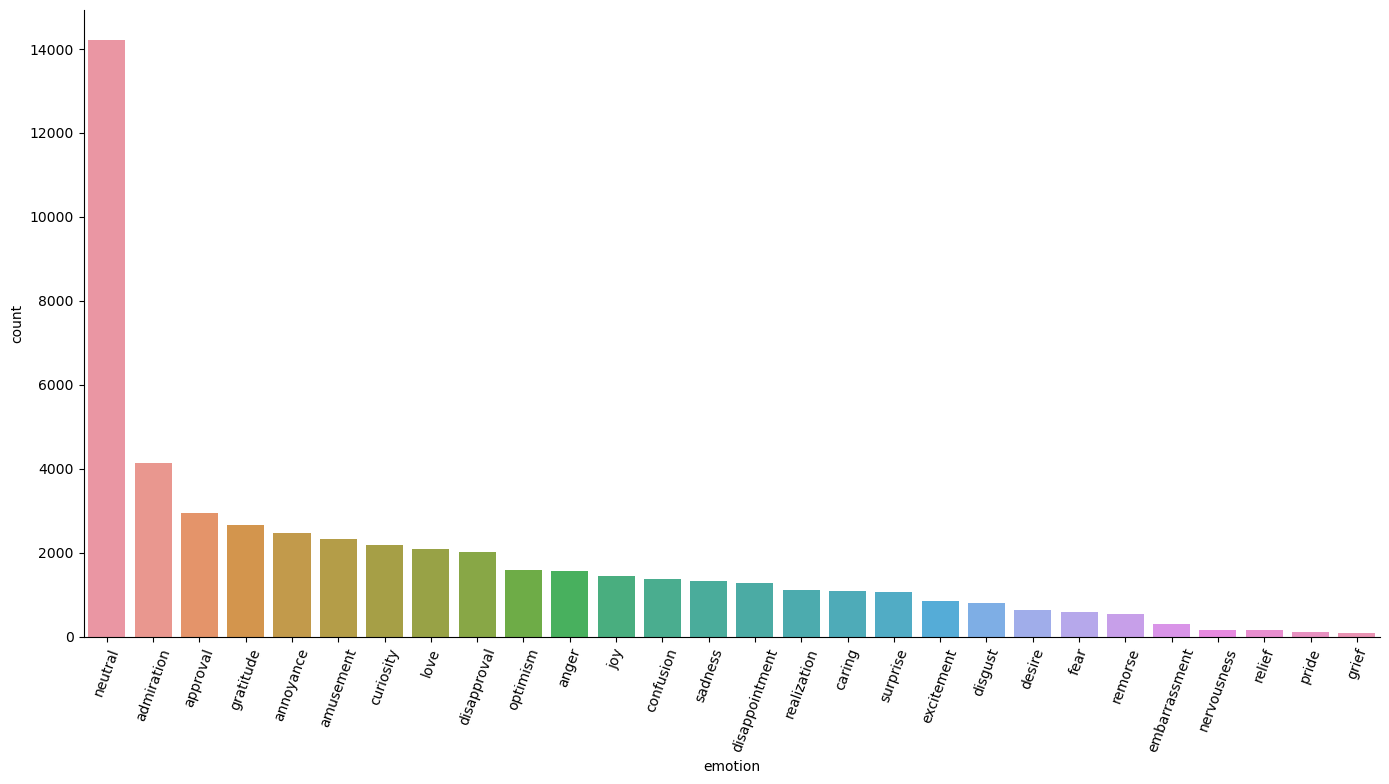

In [6]:
num_emotions = df[emotions.emotions_name.tolist()].sum(axis=0)
num_emotions = num_emotions.reset_index(name='count')
num_emotions = num_emotions.rename(columns={'index':'emotion'})
num_emotions = num_emotions.sort_values(by='count', ascending=False)

ax = sns.catplot(x = 'emotion', y = 'count',data=num_emotions, kind="bar",height=7, aspect=2)
_ = ax.set_xticklabels(rotation=70)

## Pre proceso para construcción del modelo

De esta forma podemos ver que el sentimiento "neutral" es el de mayor frecuencia, el cual es casi 3 veces "admiration" el cual corresponde a la segunda mayoría. Ahora pre procesando los textos para trabajarlos se crea la siguiente función que se encarga de eliminar algunos caracteres.

In [7]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

Definiendo el 'X' como el texto ya pre procesado y el "y" como la emoción etiquetada a ese texto.

In [8]:
X = []
sentences = list(df["text"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = df[emotions.emotions_name.tolist()]

Spit data en train y test, considerando un 80% para entrenamiento y 20% para test.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Exportamos la data ya pre-procesada

In [10]:
pd.Series(X_train).to_csv('../data/X_train.csv',index=False,header=None)
y_train.to_csv('../data/y_train.csv',index=False)
pd.Series(X_test).to_csv('../data/X_test.csv',index=False,header=None)
y_test.to_csv('../data/y_test.csv',index=False)

Ahora necesitamos convertir el texto ("X") en un embedded vector con un tokenizer function.

In [11]:
# Cargamos la data exportada 
X_train = list(itertools.chain(*pd.read_csv('../data/X_train.csv',header=None).values.tolist()))
X_test = list(itertools.chain(*pd.read_csv('../data/X_test.csv',header=None).values.tolist()))

# Tokenizer function
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(X_train)

# Tokenizer train y test
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Tamaño del vocabulario
vocab_size = len(tokenizer.word_index) + 1

# Máxima cantidad de caracteres por texto
maxlen = 40

# Padding con zeros al final de cada fila
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

Crear variables de salida para cada emoción

In [12]:
# Cargar la Data exportada
y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')

# Obtener los nombres de las columnas
column_names = emotions.emotions_name.tolist()

y_train_lst = []
y_test_lst = []
# Crear variables locales para cada columna y una lista con las respectivas variables.
for i, col in enumerate(column_names):
    globals()['y{}_train'.format(i)] = y_train[[col]].values
    globals()['y{}_test'.format(i)] = y_test[[col]].values

    y_train_lst.append(globals()['y{}_train'.format(i)] )
    y_test_lst.append(globals()['y{}_test'.format(i)] )

Cargamos la data ya entrenada del dataset 'glove.6B.100d.txt' para agregarlo como un embedding_layer en nuestro modelo.
Este .txt es posible descargarlo del siguiente link: https://nlp.stanford.edu/projects/glove/

In [13]:
glove_file = open('../data/glove.6B.100d.txt', encoding="utf8")
embeddings_dictionary = dict()
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## Construcción del Modelo

En esta oportunidad vamos a construir un modelo donde cada salida tendra un dense layer para cada emoción

In [14]:
# Input layer
input_1 = Input(shape=(maxlen,))

# Embedding layer pre trained
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_1)

# LSTM layer con 128 neuronas 
LSTM_Layer1 = LSTM(128)(embedding_layer)

# Crear dense layer para cada columna
output_lst = []
for i, col in enumerate(column_names):
    globals()['output{}'.format(i)] = Dense(1, activation='hard_sigmoid')(LSTM_Layer1)
    output_lst.append(globals()['output{}'.format(i)])

# Compilar modelo
model = Model(inputs=input_1, outputs=output_lst)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

Resumen del Modelo

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 100)      2291500     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, 128)          117248      ['embedding[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 1)            129         ['lstm[0][0]']                   
                                                                                              

Entrenamiento del modelo

In [16]:
history = model.fit(x=X_train, y=y_train_lst, batch_size=32768, epochs=18, verbose=1, validation_split=0.2)

Epoch 1/18
1/1 [==============================] - 19s 19s/step - loss: 19.4092 - dense_loss: 0.6938 - dense_1_loss: 0.6936 - dense_2_loss: 0.6939 - dense_3_loss: 0.6935 - dense_4_loss: 0.6923 - dense_5_loss: 0.6931 - dense_6_loss: 0.6953 - dense_7_loss: 0.6923 - dense_8_loss: 0.6935 - dense_9_loss: 0.6928 - dense_10_loss: 0.6940 - dense_11_loss: 0.6927 - dense_12_loss: 0.6927 - dense_13_loss: 0.6920 - dense_14_loss: 0.6919 - dense_15_loss: 0.6920 - dense_16_loss: 0.6950 - dense_17_loss: 0.6934 - dense_18_loss: 0.6934 - dense_19_loss: 0.6933 - dense_20_loss: 0.6931 - dense_21_loss: 0.6935 - dense_22_loss: 0.6919 - dense_23_loss: 0.6934 - dense_24_loss: 0.6941 - dense_25_loss: 0.6924 - dense_26_loss: 0.6936 - dense_27_loss: 0.6925 - dense_acc: 0.3664 - dense_1_acc: 0.0913 - dense_2_acc: 0.0478 - dense_3_acc: 0.1017 - dense_4_acc: 0.9174 - dense_5_acc: 0.4758 - dense_6_acc: 0.0417 - dense_7_acc: 0.9473 - dense_8_acc: 0.3868 - dense_9_acc: 0.9222 - dense_10_acc: 0.0563 - dense_11_acc: 0.83

Evaluar métricas

In [17]:
score = model.evaluate(x=X_test, y=y_test_lst, verbose=1,return_dict=True)

272/272 [==============================] - 4s 15ms/step - loss: 7.0422 - dense_loss: 0.3543 - dense_1_loss: 0.2424 - dense_2_loss: 0.1595 - dense_3_loss: 0.2742 - dense_4_loss: 0.2577 - dense_5_loss: 0.1280 - dense_6_loss: 0.3710 - dense_7_loss: 0.2149 - dense_8_loss: 0.2950 - dense_9_loss: 0.1289 - dense_10_loss: 0.2274 - dense_11_loss: 0.1492 - dense_12_loss: 0.1030 - dense_13_loss: 0.1210 - dense_14_loss: 0.2061 - dense_15_loss: 0.2698 - dense_16_loss: 0.6693 - dense_17_loss: 0.3407 - dense_18_loss: 0.2027 - dense_19_loss: 0.1316 - dense_20_loss: 0.1649 - dense_21_loss: 0.0426 - dense_22_loss: 0.3962 - dense_23_loss: 0.4801 - dense_24_loss: 0.0689 - dense_25_loss: 0.2836 - dense_26_loss: 0.1171 - dense_27_loss: 0.6419 - dense_acc: 0.9006 - dense_1_acc: 0.9478 - dense_2_acc: 0.9628 - dense_3_acc: 0.9444 - dense_4_acc: 0.9335 - dense_5_acc: 0.9756 - dense_6_acc: 0.9703 - dense_7_acc: 0.9470 - dense_8_acc: 0.9853 - dense_9_acc: 0.9719 - dense_10_acc: 0.9559 - dense_11_acc: 0.9820 - den

Evolucion del loss

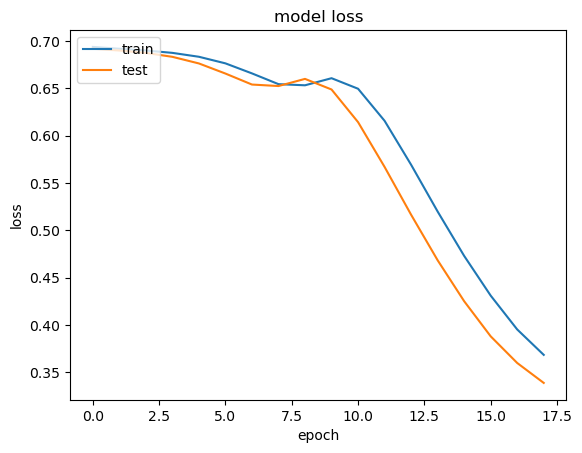

In [18]:
plt.plot(history.history['dense_loss'])
plt.plot(history.history['val_dense_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

Accuracy

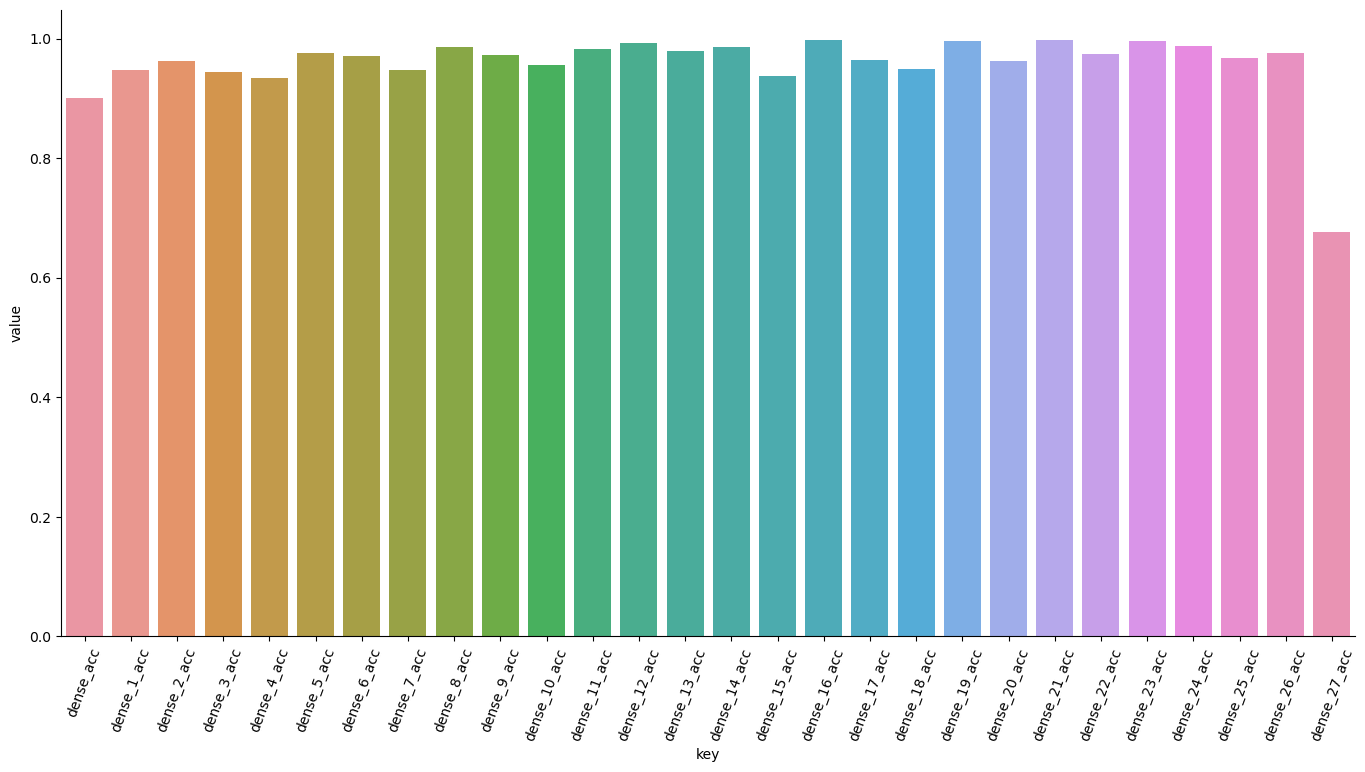

In [19]:
acc_dic = {k: v for k, v in score.items() if 'acc' in k}
data = [(key, value) for key, value in acc_dic.items()]
df = pd.DataFrame(data, columns=['key', 'value'])

ax = sns.catplot(x = 'key', y = 'value',data=df, kind="bar",height=7, aspect=2)
_ = ax.set_xticklabels(rotation=70)

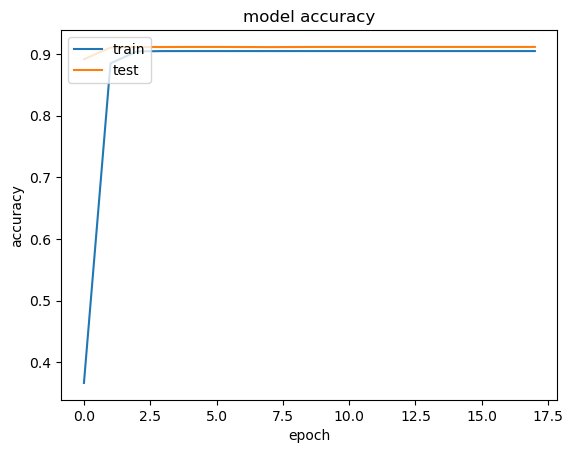

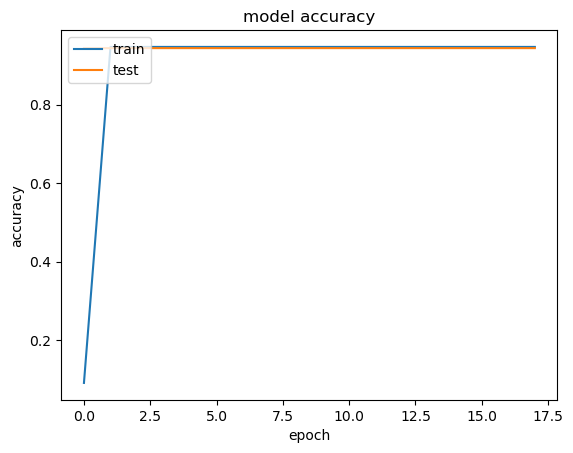

In [20]:
plt.plot(history.history['dense_acc'])
plt.plot(history.history['val_dense_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['dense_1_acc'])
plt.plot(history.history['val_dense_1_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Prediccion data no etiquetada

Cargamos el set de datos no etiquetados

In [21]:
dataset_nolabel = pd.read_csv('../data/text_classification_test.csv')
dataset_nolabel.sample(5,random_state=42)  

,text,id
79,Eff your video - love Canada 🇨🇦 Stupid geolock,ee3cjuy
4139,"I know they are treated very well, but some of...",een5sns
1643,Man I love this team. No I hate this team. No ...,ed69lg9
167,I can't watch Isco rotting on the bench and LV...,ed6baxy
439,I hieaa i just trip out how your lds and not k...,efe50zd


Preparamos el X para que tenga el mismo formato

In [22]:
# Nueva variable
X_new = []
sentences = list(dataset_nolabel["text"])
for sen in sentences:
    X_new.append(preprocess_text(sen))

# Tokenizer data
X_new = tokenizer.texts_to_sequences(X_new)

# Padding con zeros al final de cada fila
X_new = pad_sequences(X_new, padding='post', maxlen=maxlen)

Realizamos la predicción

In [23]:
Y_new = model.predict(X_new)

170/170 [==============================] - 2s 10ms/step


Agregamos el valor predicho para cada columna

In [24]:
# Se agregan las predicciones como nuevas columnas
for i,value in enumerate(Y_new):
    dataset_nolabel[column_names[i]] = value

# Si el valor predicho es mayor a un valor específico se considera que si queda etiquetado con esa emoción
dataset_nolabel[column_names] = dataset_nolabel[column_names] > 0.25
dataset_nolabel[column_names] = dataset_nolabel[column_names].astype(int)

Ahora se agregan como lista de emociones e id

In [25]:
# Se agrega una lista de todas las emocioones
dataset_nolabel['emotion_name'] = dataset_nolabel[column_names].apply(lambda x: [col for col in x.index if x[col] == 1], axis=1)

# Se agrega una lista con los respectivos id
string_to_id_dict = dict(zip(emotions['emotions_name'], emotions['emotion_id']))
# Create a new column that maps each string in the list to its id
dataset_nolabel['emotion_id'] = dataset_nolabel['emotion_name'].apply(lambda x: [string_to_id_dict.get(string) for string in x])
dataset_nolabel['emotion_id'] = dataset_nolabel['emotion_id'].apply(lambda x: ','.join(map(str, x)) )

Data predicha

In [26]:
dataset_nolabel[['text','id','emotion_id']].sample(5,random_state=42)  

,text,id,emotion_id
79,Eff your video - love Canada 🇨🇦 Stupid geolock,ee3cjuy,"6,16,17,23,27"
4139,"I know they are treated very well, but some of...",een5sns,"6,16,17,23,27"
1643,Man I love this team. No I hate this team. No ...,ed69lg9,"6,16,17,23,27"
167,I can't watch Isco rotting on the bench and LV...,ed6baxy,"6,16,17,23,27"
439,I hieaa i just trip out how your lds and not k...,efe50zd,"6,16,17,23,27"


Exportar data

In [27]:
dataset_nolabel[['text','id','emotion_id']].to_csv('../data/pred_text_classification_test.csv',index=False)

## Disclaimer

- Lei mal el enunciado una vez que terminé el desafio al final del tiempo límite por lo cual no tuve chance de realizar otro modelo, lei: "el cliente pide que construyamos modelos basados en redes neuronales".
- El modelo no logra hacer predicciones de buena forma, quizas intentanto con distintas arquitecturas podría ser una solución al igual que calibrar algunos parámetros.
- Quedan pendientes el uso del resto de métricas (precision, recall y f1-score) que por cosa de tiempo no pude implementarlas de buena forma.